Shape of the connectivity matrix W: (2952, 2952)
Connectivity matrix range after min-max: min=0.0000, max=1.0000


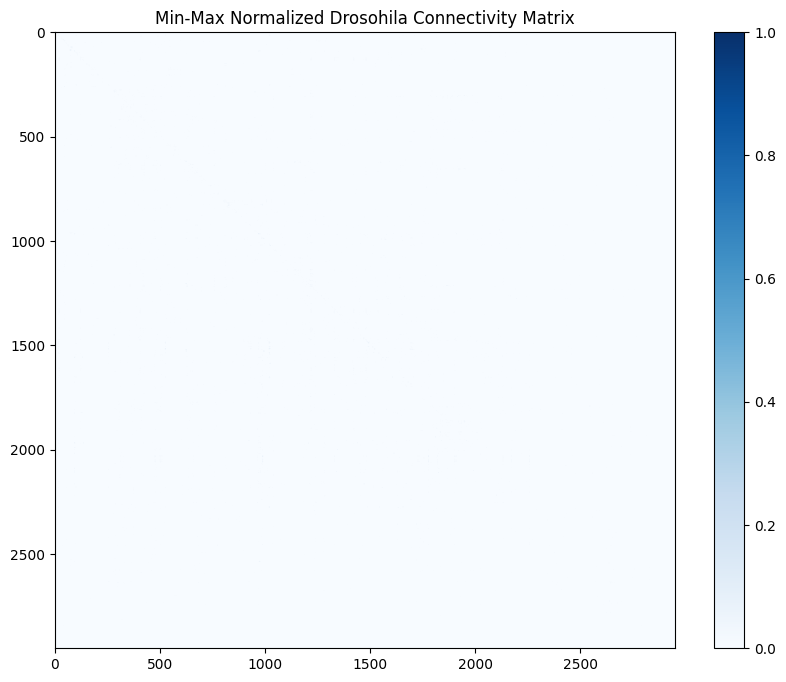

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import pickle

csv_path = './data/ad_connectivity_matrix.csv'
W_df = pd.read_csv(csv_path, index_col=0, header=0)

W = W_df.values.astype(np.float32)

# Min-max normalization so entire matrix is in [0, 1]
W_min = W.min()
W_max = W.max()
W = (W - W_min) / (W_max - W_min + 1e-8)

# helps stability
# W = W * 0.001

print("Shape of the connectivity matrix W:", W.shape)
print(f"Connectivity matrix range after min-max: min={W.min():.4f}, max={W.max():.4f}")

plt.figure(figsize=(10, 8))
plt.imshow(W, cmap='Blues', aspect='auto')
plt.title("Min-Max Normalized Drosohila Connectivity Matrix")
plt.colorbar()
plt.show()

In [ ]:
class DrosophilaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, W_matrix):
        super(DrosophilaRNN, self).__init__()
        # Map input -> hidden
        self.input_to_hidden = nn.Linear(input_size, hidden_size, bias=True)
        # Map hidden -> output
        self.hidden_to_output = nn.Linear(hidden_size, output_size, bias=True)
        # for trainable W use nn.Parameter
        self.register_parameter("W_matrix", nn.Parameter(
            torch.tensor(W_matrix, dtype=torch.float32)
        ))
        # self.W_matrix = torch.tensor(W_matrix, dtype=torch.float32)
        self.hidden_size = hidden_size

    def forward(self, x):
        """
        x 的形状: (batch_size, time_steps, input_size)
        这里的 time_steps = 28 (行数)
        """
        batch_size, time_steps, _ = x.shape
        # r(0) = 0
        r_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(time_steps):
            E_t = x[:, t, :]                    # (batch_size, input_size)
            E_t_hidden = self.input_to_hidden(E_t)
            r_prev = r_t # for residual
            
            # 
            r_t = r_t @ self.W_matrix          
            r_t = r_t + E_t_hidden + r_prev    # residual/skip
            r_t = torch.relu(r_t)

        out = self.hidden_to_output(r_t)       # (batch_size, output_size)
        return out

def load_mnist_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    batch_size = 64
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_model(W, device, num_epochs=10, batch_size=64, tag="drosophila"):

    train_loader, test_loader = load_mnist_data(batch_size=batch_size)

    input_size = 28
    hidden_size = W.shape[0]
    output_size = 10
    
    model = DrosophilaRNN(input_size, hidden_size, output_size, W).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Training [{tag}] Epoch {epoch+1}/{num_epochs}")
            for images, labels in tepoch:
                # images shape: (batch_size, 1, 28, 28)
                images = images.squeeze(1).to(device)  # -> (batch_size, 28, 28)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
                tepoch.set_postfix(
                    loss=loss.item(), accuracy=100. * correct / total
                )

        epoch_acc = correct / total
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/total:.4f}, "
              f"Accuracy: {epoch_acc:.4f}")

    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.squeeze(1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    test_accuracy = test_correct / test_total
    print(f"[{tag}] Test Accuracy: {test_accuracy:.4f}")

    results = {
        'train_accuracies': train_accuracies,
        'test_accuracy': test_accuracy,
        'tag': tag
    }

    with open(f'results_{tag}.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

size = 2952  

train_model(W, device, num_epochs=3, batch_size=64, tag="drosophila_origin")

W_random = torch.randn(size, size)
train_model(W_random, device, num_epochs=3, batch_size=64, tag="random_origin")

Using device: cpu


Training [drosophila_origin] Epoch 1/3: 100%|██████████| 938/938 [05:51<00:00,  2.67batch/s, accuracy=11.2, loss=59.5]   


Epoch 1/3, Loss: 22270.9071, Accuracy: 0.1125


Training [drosophila_origin] Epoch 2/3: 100%|██████████| 938/938 [05:29<00:00,  2.85batch/s, accuracy=22.2, loss=26.7]


Epoch 2/3, Loss: 35.8033, Accuracy: 0.2219


Training [drosophila_origin] Epoch 3/3: 100%|██████████| 938/938 [03:59<00:00,  3.92batch/s, accuracy=39.1, loss=3.52]


Epoch 3/3, Loss: 9.7887, Accuracy: 0.3910


/var/folders/t_/91rqdbn53njdsvsqb1hgqdw80000gn/T/ipykernel_89388/3930479659.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(W_matrix, dtype=torch.float32)


[drosophila_origin] Test Accuracy: 0.5691


Training [random_origin] Epoch 1/3: 100%|██████████| 938/938 [03:58<00:00,  3.94batch/s, accuracy=9.87, loss=nan]


Epoch 1/3, Loss: nan, Accuracy: 0.0987


Training [random_origin] Epoch 2/3: 100%|██████████| 938/938 [04:04<00:00,  3.84batch/s, accuracy=9.87, loss=nan]


Epoch 2/3, Loss: nan, Accuracy: 0.0987


Training [random_origin] Epoch 3/3: 100%|██████████| 938/938 [04:05<00:00,  3.82batch/s, accuracy=9.87, loss=nan]


Epoch 3/3, Loss: nan, Accuracy: 0.0987
[random_origin] Test Accuracy: 0.0980


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


train_model(W, device, num_epochs=3, batch_size=64, tag="drosophila_fixw")

size = 2952  
W_random = torch.randn(size, size)
train_model(W_random, device, num_epochs=3, batch_size=64, tag="random_fixw")

Using device: cpu


Training [drosophila_fixw] Epoch 1/3: 100%|██████████| 938/938 [02:00<00:00,  7.77batch/s, accuracy=39.7, loss=1.51]


Epoch 1/3, Loss: 1.8062, Accuracy: 0.3972


Training [drosophila_fixw] Epoch 2/3: 100%|██████████| 938/938 [02:01<00:00,  7.73batch/s, accuracy=58.3, loss=1.23]


Epoch 2/3, Loss: 1.3690, Accuracy: 0.5833


Training [drosophila_fixw] Epoch 3/3: 100%|██████████| 938/938 [02:00<00:00,  7.81batch/s, accuracy=65.5, loss=1.01] 


Epoch 3/3, Loss: 1.1760, Accuracy: 0.6547


/var/folders/t_/91rqdbn53njdsvsqb1hgqdw80000gn/T/ipykernel_89388/1079288553.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.W_matrix = torch.tensor(W_matrix, dtype=torch.float32)


[drosophila_fixw] Test Accuracy: 0.7025


Training [random_fixw] Epoch 1/3: 100%|██████████| 938/938 [01:57<00:00,  7.96batch/s, accuracy=9.87, loss=nan]


Epoch 1/3, Loss: nan, Accuracy: 0.0987


Training [random_fixw] Epoch 2/3: 100%|██████████| 938/938 [01:54<00:00,  8.17batch/s, accuracy=9.87, loss=nan]


Epoch 2/3, Loss: nan, Accuracy: 0.0987


Training [random_fixw] Epoch 3/3: 100%|██████████| 938/938 [01:56<00:00,  8.04batch/s, accuracy=9.87, loss=nan]


Epoch 3/3, Loss: nan, Accuracy: 0.0987
[random_fixw] Test Accuracy: 0.0980


In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    train_model(W, device, num_epochs=3, batch_size=64, tag="drosophila_grad_false")

if __name__ == "__main__":
    main()

Using device: cpu


Training [drosophila_grad_false] Epoch 1/3: 100%|██████████| 938/938 [04:04<00:00,  3.83batch/s, accuracy=84.9, loss=0.402] 


Epoch 1/3, Loss: 0.4759, Accuracy: 0.8486


Training [drosophila_grad_false] Epoch 2/3: 100%|██████████| 938/938 [05:55<00:00,  2.64batch/s, accuracy=94.5, loss=0.0296]


Epoch 2/3, Loss: 0.1736, Accuracy: 0.9449


Training [drosophila_grad_false] Epoch 3/3: 100%|██████████| 938/938 [06:04<00:00,  2.57batch/s, accuracy=96.2, loss=0.0289]


Epoch 3/3, Loss: 0.1217, Accuracy: 0.9615
[drosophila_grad_false] Test Accuracy: 0.9550


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
size = 2952 
W_random = torch.randn(size, size)
W_random = W_random * 0.001 # rescale 
train_model(W_random, device, num_epochs=3, batch_size=64, tag="drosophila_random_fixw")

/var/folders/t_/91rqdbn53njdsvsqb1hgqdw80000gn/T/ipykernel_89388/1079288553.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.W_matrix = torch.tensor(W_matrix, dtype=torch.float32)


Using device: cpu


Training [drosophila_random_fixw] Epoch 1/3: 100%|██████████| 938/938 [03:17<00:00,  4.74batch/s, accuracy=42.5, loss=1.66]


Epoch 1/3, Loss: 1.7361, Accuracy: 0.4249


Training [drosophila_random_fixw] Epoch 2/3: 100%|██████████| 938/938 [03:17<00:00,  4.74batch/s, accuracy=61.2, loss=1.19] 


Epoch 2/3, Loss: 1.2878, Accuracy: 0.6120


Training [drosophila_random_fixw] Epoch 3/3: 100%|██████████| 938/938 [03:16<00:00,  4.77batch/s, accuracy=68.5, loss=1.19] 


Epoch 3/3, Loss: 1.0902, Accuracy: 0.6851
[drosophila_random_fixw] Test Accuracy: 0.7261
